# Objectives:
We need to build medical vocabulary (word dictionary) for spelling checker. The following dataset was found useful for building vocab:(https://www.kaggle.com/datasets/jpmiller/layoutlm/data)

Before building the vocab, the following questions needs to be clarified:
1. What the dataset contains (EDA)?
2. Which feature needed?
3. What is the expected outcome?

Once, these questions are clarified, we can proceed building a custom NLTK corpus.

In [14]:
import pandas as pd
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
import statistics

from nltk.translate.bleu_score import corpus_bleu

from app_config import Configuration

In [15]:
df = pd.read_csv('data/medquad-kaggle-johnm.csv')

In [ ]:
df.shape

In [ ]:
df.head(2)

## 1. What the dataset contains?
We need a corpus that contains medical words for building a medical dictionary (vocab). Therefore, we need to investigate whether the obtained corpus contains the required.

In [ ]:
# Let's investigate the data types and columns in the dataset.
df.info()

In [ ]:
# It appears there are four columns, and all columns contains string datatype.
# Let's investigate which column will be more sensible for building the vocab.
df.describe()

Logically assumption: average length of answers should be greater than questions; means, more texts in answers column. \
Let's investigate the assumption.


In [16]:
# The following function returns token count for given text, it will be used for calculating
# average tokens for questions & answers.
def token_count(x):
    return len(word_tokenize(x))

Before we use the word_tokenizer to count the tokens in each column, we need to drop the missing values to avoid exceptions.

In [ ]:
# Let's find out the missing values first.
df.isnull().sum()

In [17]:
# From the above we can conclude, question column doesn't have missing values meanwhile, answer column have 5.
cnt = df['question'].apply(token_count).sum()
print(f'Questions have {cnt} count of tokens.')

Questions have 146185 count of tokens.


In [18]:
# Drop only rows with missing values on the answer columns.
df = df[df['answer'].notna()]

cnt = df['answer'].apply(token_count).sum()
print(f'Answers have {cnt} count of tokens.')

Answers have 3731909 count of tokens.


## 2. Which feature needed?
In the EDA, two columns (question & answer) from the dataset was expected to have the required texts to build the vocab. For that, an hypothesis made that the answer column would have longer text than question column. The hypothesis was true, and therefore, the text from the answer column will be preprocessed for building the corpus.\

In the preprocessing to build the vocab, we need to:
1. Clean the text from answer column - only words (others are stripped)
2. Get lemma for each words to avoid redundant word with the same meaning
3. Only include unique words into vocab

In [21]:
from importlib import reload
# 1. Clean the text from answer column - only words (others are stripped)
from nltk.corpus import stopwords
import utils.regex as rx

reload(rx)

# Acquire the stop words from NLTK corpus.
stop_words = stopwords.words('english')

# To store all the processed tokens.
corpus_token_list = []

# Tracing value for debugging.
i = 0
token_cnt = 0
filtered_token_cnt = 0
cleanse_data = pd.DataFrame(columns=['row', 'original', 'cleansed'])
try:
    for text in df['answer']:
        # Remove URLs.
        clean_text = rx.remove_url(text)
        # # Remove HTML tags.
        clean_text = rx.remove_html(clean_text)
        # # Remove bracketed words (usually acronyms).
        clean_text = rx.remove_bracketed_text(clean_text)
        # Transform contradictions to full form first before removing stop words.
        clean_text = rx.transform_contractions(clean_text)
        # Get only words.
        clean_text = rx.get_words(clean_text.lower())
        # Remove all extra spaces.
        clean_text = rx.remove_extra_space(clean_text)

        # For tracing raw to cleanse.
        cleanse_data.loc[len(cleanse_data)] = [i, text, clean_text]

        # Tokenize the text.
        tokens = word_tokenize(clean_text)

        # Tracing unfiltered-token count.
        token_cnt += len(tokens)

        # Filter stop words.
        filtered_text = [w for w in tokens if not w.lower() in stop_words]

        # Tracing filtered-token count for debugging.
        filtered_token_cnt += len(filtered_text)

        # Add the filtered words into corpus token_list.
        corpus_token_list.append(filtered_text)

        # Tracing row-count for debugging.
        i += 1
except Exception as e:
    print(f'Exception {e} in {i}.')

print(f'Rows processed:[{i}], unfiltered tokens:[{token_cnt}], filtered tokens:[{filtered_token_cnt}]')
print(f'Corpus entry count:[{len(corpus_token_list)}].')

cleanse_data.to_csv('data/cleanse-data.csv', index=False)

Rows processed:[16407], unfiltered tokens:[3151455], filtered tokens:[1885840]
Corpus entry count:[16407].


In [22]:
cleanse_data.iloc[580:590]

,row,original,cleansed
580,580,Here are links to more information about P.A.D...,here are links to more information about p a d...
581,581,"Many Reasons for Abuse Drug abuse, whether pre...",many reasons for abuse drug abuse whether pres...
582,582,Addiction is a chronic disease in which a pers...,addiction is a chronic disease in which a pers...
583,583,Physical dependence is a normal process that c...,physical dependence is a normal process that c...
584,584,"A persons behavior, especially changes in beha...",a persons behavior especially changes in behav...
585,585,The prescription medications most commonly abu...,the prescription medications most commonly abu...
586,586,Medications affect older people differently th...,medications affect older people differently th...
587,587,Marijuana is the most abused illicit drug amon...,marijuana is the most abused illicit drug amon...
588,588,"Although under federal law, marijuana is illeg...",although under federal law marijuana is illega...
589,589,"Not always. Some warning signs, such as sleep ...",not always some warning signs such as sleep pr...


In [37]:
# 2. Get lemma for each words to avoid redundant word with the same meaning
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# List for storing token's lemma.
corpus_lemma_list = []

# Tracing value for debugging.
i = 0
token_cnt = 0
filtered_token_cnt = 0
# normalized_data = pd.DataFrame(columns=['row', 'original', 'normalized'])
trace_list = []
for entry in corpus_token_list:
    entry_list = []
    for token in entry:
        normalized_token = lemmatizer.lemmatize(token)
        entry_list.append(normalized_token)

        # For tracing raw to cleanse.
        trace_list.append([i, token, normalized_token])
        # normalized_data.loc[len(normalized_data)] = [i, token, normalized_token]

        filtered_token_cnt += 1

    # Add entry (token for single answer) in the list for further processing.
    corpus_lemma_list.append(entry_list)
    i = i + 1

print(f'Rows processed:[{i}], filtered tokens:[{filtered_token_cnt}]')
print(f'Corpus entry count:[{len(corpus_token_list)}].')

normalized_data = pd.DataFrame(trace_list, columns=['row', 'original', 'normalized'])
normalized_data.to_csv('data/normalized-data.csv', index=False)

Rows processed:[16407], filtered tokens:[1885840]
Corpus entry count:[16407].


In [39]:
normalized_data.iloc[1280:1290]

,row,original,normalized
1280,14,pressure,pressure
1281,14,often,often
1282,14,called,called
1283,14,silent,silent
1284,14,killer,killer
1285,14,usually,usually
1286,14,symptoms,symptom
1287,14,occasionally,occasionally
1288,14,headaches,headache
1289,14,may,may


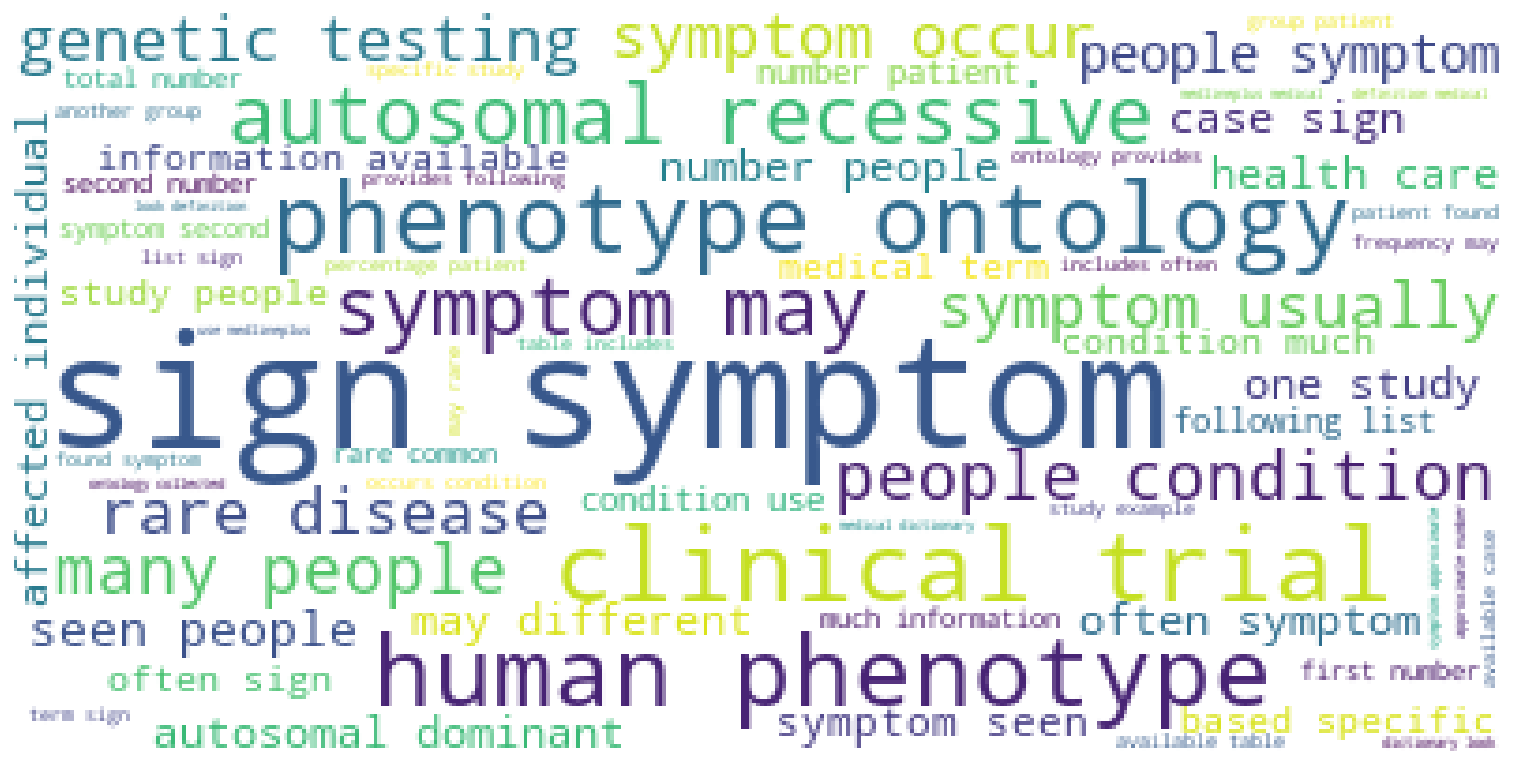

In [40]:
# Let's see the most frequent words in the vocab.
import wordcloud
import matplotlib.pyplot as plt

text = ''
for entry in corpus_lemma_list:
    for token in entry:
        text += ' ' + token

word_cloud = wordcloud.WordCloud(background_color='white').generate(text)
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [41]:
# 3. Only include unique words into vocab

# Final vocab to store the lemmas from the corpus.
vocab_list = []
for entry in corpus_lemma_list:
    for word in entry:
        if word not in vocab_list:
            vocab_list.append(word)

print(f'Vocab entry count (unique words):[{len(vocab_list)}].')

Vocab entry count (unique words):[23319].


## 3. What is the expected outcome?
Now, we have the unique medical words stored in vocab and ready for creating a NLTK corpus for spelling checking.

In [42]:
# Save the vocab into custom NLTK corpus format.

import os

# Get corpus path from app config.
config = Configuration()

# Organize the vocab into custom folder.
corpus_dir = config.config_values['corpus_medical']
if not os.path.exists(corpus_dir):
    os.makedirs(corpus_dir)

# Write words (lemma) to separate files in the corpus directory.
# for i, text in enumerate(vocab_list):
#     with open(os.path.join(corpus_dir, f'doc{i + 1}.txt'), 'w', encoding='utf-8') as file:
#         file.write(text)

corpus_name = 'medical.txt'
for i, text in enumerate(vocab_list):
    with open(os.path.join(corpus_dir, corpus_name), 'a', encoding='utf-8') as file:
        file.write(text + '\r\n')

In [43]:
# Load the custom NLTK corpus.
from nltk.corpus import PlaintextCorpusReader

# Step 3: Create an NLTK Corpus Reader
corpus = PlaintextCorpusReader(corpus_dir, '.*\.txt')

print(f'There are {len(corpus.words())} words in custom corpus.')

There are 23319 words in custom corpus.


In [44]:
# Testing: load the corpus and perform edit-distance for given real-word.
from nltk import edit_distance

test_word = 'glacoma'

if test_word not in corpus.words():
    print(f'Test word {test_word} not in corpus.')
    for w in corpus.words():
        m = edit_distance(test_word, w)
        if m == 1:
            print(f'Word {w} edit distance is {m}.')
            break
else:
    print(f'Test word {test_word} exists in corpus.')


Test word glacoma not in corpus.
Word glaucoma edit distance is 1.
